# Data preparation utilities
> Functions that prepare label files and split the data into train validation and test sets

In [4]:
#hide
# default_exp dataprep_utils
from nbdev.showdoc import *
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [5]:
# export
import random
from  cellsegment.core import *
from cellsegment.json_utils import *
import json
import shutil

import pandas
from fastai.vision import *
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.exposure import histogram
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os


## Typical Usage
Imports  
Define directories  
get stats on images  
Well Croping & Resizing [link to another section](#Well-Croping-&-Resizing)  
Convert directory of CSV files to JSON files [link to another section](#Another-section)  
Resize jpg & json files  [link to another section](#Another-section)
Create label png images based on Json files and store in dest directory") [link to another section](#Another-section) 
Split into Train, Val and Test [link to another section](#Another-section) 
Save label files without color pallet info [link to another section](#Another-section) 
Test Create DataBunch [link to another section](#Test-Create-DataBunch) 
Show example images  [link to another section](#Show_example_images)

### Default Class Labels

In [6]:
# export

CLASS_LABELS = {
        'Background':  {'Code': 0,   'Fill': (0, 0, 0, 127)},
        'Liver Fluke': {'Code': 11,  'Fill': (255, 0, 0, 127)},
        'Rumen Fluke': {'Code': 40,  'Fill': (0, 255, 0, 127)},
        'Other':       {'Code': 255, 'Fill': (0, 0, 255, 127)}
    }
FILENAME_TRIM = False

## Well Croping & Resizing

In [7]:
# export
def crop2well(img, thres_adjust=1., bg_color=[0,0,0], op='crop'):
    '''Returns a square colour and gray image centered on the well with width same as the height.
    thres_adjust is  optional otsu threshold scaling multiplier
    Also returns the offset to the original image and the well region properties'''
    assert op=='mask' or op=='crop', 'op must be either "mask" or "crop"), the value was {}'.format(op)

    width = img.shape[0]
    img_gray = rgb2gray(img)
    thresh = threshold_otsu(img_gray)
    img_thresholded = closing(img_gray > thresh * thres_adjust, square(3))
    label_image = label(img_thresholded)

    well_region = None
    for region in regionprops(label_image):
        if region.area >= 100000:
            well_region = region
    # if region_center == 0: raise ValueError('No region_center found')

    r0, c0, r1, c1 = well_region.bbox
    if op=='mask':
        well_circle_mask = pad(well_region.convex_image, (img.shape[:2]), well_region.bbox[:2])
        img_crop = img[r0:r1, c0:c1]
        img_rgb = pad(img_crop, img.shape, well_region.bbox[:2], bg_color=bg_color)
        return img_rgb, img_thresholded, well_circle_mask, well_region
    elif op=='crop':
        well_center = (c0 + c1)//2
        offset = well_center - width//2
        img_rgb = img[:, offset:well_center + width//2, :]
        return img_rgb, offset

In [8]:
# export
def well_circle_mask(img, well_regionprops):
    return pad(well_regionprops.convex_image, (img.shape[:2]), well_regionprops.bbox[:2])

In [9]:
# export
def check_well_crop(img, well_regionprops):
    assert img.shape[0] == img.shape[1], "Expecting the cropped  well image to be square"
    bbox = well_regionprops.bbox
    bbox_area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    bbox_squareness = (bbox[2] - bbox[0]) / (bbox[3] - bbox[1])
    bbox_percent = bbox_area / (img.shape[0] * img.shape[0])
    max_well_area = 3.14156 * img.shape[0] * img.shape[0] / 4
    illum_well_percent = well_regionprops.area / max_well_area

    print('bbox_percent', bbox_percent)
    print('bbox_squareness', bbox_squareness)
    print('illum_well_percent', illum_well_percent)
    print('illum_well_saturation', illum_well_percent)
    

In [10]:
# export
def resize_crop2well_one(fn, i, src_path, dest_path, height):
    img = PIL.Image.open(src_path / fn.name)
    img_w, img_h = img.size
    scale = float(height / img_h)
    shape = (int(img_w * scale), height)
    img_cropped, offset = crop2well(np.asarray(img.resize(shape)))
    img_cropped = PIL.Image.fromarray(img_cropped.astype('uint8'), 'RGB')
    img_cropped.save(dest_path / f'{fn.stem}|{scale:.6f}|{offset:3}|.jpg', quality=90)

# def resize_crop2center_one(fn, i, src_path, dest_path, height):
#     img = PIL.Image.open(src_path / fn.name)
#     img_w, img_h = img.size
#     scale = float(height / img_h)
#     shape = (int(img_w * scale), height)
#     img_cropped, offset = crop2well(np.asarray(img.resize(shape)))
#     img_cropped = PIL.Image.fromarray(img_cropped.astype('uint8'), 'RGB')
#     img_cropped.save(dest_path / f'{fn.stem}|{scale:.6f}|{offset:3}|.jpg', quality=90)

## Pandas and CSV

In [11]:
# export
def shuffle_csv(file_csv,random_state=None):
    df = pandas.read_csv(file_csv)
    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    df.to_csv(file_csv, index=False)

In [12]:
# export
def split_filenames(file_csv, num_train=0.70, num_val=0.15):
    """
    shuffle file names, split into train valid and test and update file_data.csv with labels

    :param file_csv: csv file with file names and data
    :param num_train:
    :param num_val:
    :param seed:
    :return:
    """
    df = pandas.read_csv(file_csv)
    __number_files = df.shape[0]

    # add Op column
    operation = ['Train'] * int(__number_files * num_train)
    operation = operation + ['Valid'] * int(__number_files * num_val)
    operation = operation + ['Test'] * (__number_files - len(operation))

    df['Op'] = operation
    df.to_csv(file_csv, index=False)
    return None


## Other

In [13]:
# hide  
# TODO check for deletion
def pad(im, shape, offset, bg_color=None):
    """
    array: Array to be padded
    reference_shape: tuple of size of ndarray to create
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    will throw a ValueError if offsets is too big and the reference_shape cannot handle the offsets
    """

    # Create an array of zeros with the reference shape
    if bg_color:
        result = np.ones(shape, im.dtype)
        result = result * np.array(bg_color)
    else:
        result = np.zeros(shape, im.dtype)
    # Create a list of slices from offset to offset + shape in each dimension
    insertHere = [slice(offset[dim], offset[dim] + im.shape[dim]) for dim in range(2)]
    # Insert the array in the result at the specified offsets
    result[insertHere] = im
    return result

In [14]:
# export
def get_image_size(fn):
    return PIL.Image.open(fn).size

In [15]:
# export
def make_label_img_from_json(jdata, img, radius=20):
    """ 
    returns a label img with filled circles at places of interest
    json data contains info to markup an image with circles
    """
    if isinstance(img, np.ndarray): img = PIL.Image.fromarray(img)
    lab_img = PIL.Image.new('P', img.size)
    
    DEFAULT_LABEL_FILL = (255, 255, 255, 64)
    DEFAULT_LABEL_CODE = (255)
    num_points = 0
    label_cnt_dict = { cls[0]: {'Code': cls[1]['Code'], 'Count': 0}  for cls in CLASS_LABELS.items()}
    # for s, sh in enumerate(jdata['shapes']):
    for sh in jdata['shapes']:
        fill = DEFAULT_LABEL_FILL
        try:
            it = CLASS_LABELS[sh['label']]
            fill = it['Fill']
            code = it['Code']
            label_cnt_dict[sh['label']]['Count'] += 1
            num_points += 1
        except:
            print("Error in parsing CLASS_LABELS", sh['label'])

        # draw a circle at the circle
        if sh["shape_type"] == "circle":
            xy = np.asarray(sh["points"])
            # ave = np.mean(xy, axis=0)
            # cx, cy = ave[0], ave[1]
            cx, cy = xy[0][0], xy[0][1]
            draw = PIL.ImageDraw.Draw(img)
            draw.ellipse([cx - radius, cy - radius, cx + radius, cy + radius], outline=0, fill=fill)
            draw = PIL.ImageDraw.Draw(lab_img)
            draw.ellipse([cx - radius, cy - radius, cx + radius, cy + radius], outline=0, fill=code)
            num_points += 1

    return np.asarray(img), np.asarray(lab_img), num_points, label_cnt_dict

This function creates two markup up files

0 11


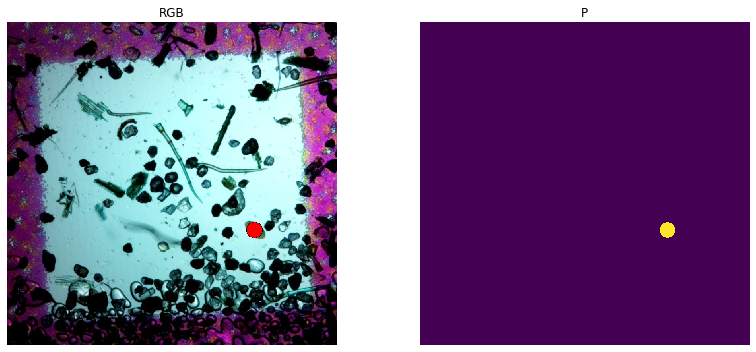

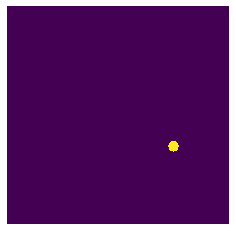

In [22]:
jdata = json.load(open(TEST_JSON))
img = np_open_image(TEST_JPG)
img, lab_img, num_points, label_cnt_dict = make_label_img_from_json(jdata, img, radius=20)
plot_images({'RGB':img, 'P':lab_img}, figsize=(12, 5))
lab_img.shape

sav_pil = PIL.Image.fromarray(lab_img.astype(np.uint8), mode='P')
sav_pil.putpalette(LABEL_COLORMAP)
fn = Path(TEST_JPG)
sav_pil.save(TEST_PNG)

load_pil = np_open_image(TEST_PNG)
show_img(np_open_image(TEST_PNG))

print(lab_img.min(), lab_img.max())

In [20]:
# export
def create_one_label(fn, json_path, lab_path, colormap):
    if isinstance(fn, str):
        fn = Path(fn)
    data = json.load(open(f'{json_path}/{fn.stem}.json'))
    # img = PIL.Image.open(f'{src_path}/{fn.stem}.jpg')
    img = PIL.Image.new('RGB', (data["imageWidth"], data["imageHeight"]), color=(0, 0, 0))
    # h = data["imageHeight"]
    # w = data["imageWidth"]
    img, lab_img, num_pnts, label_cnt_list = make_label_img_from_json(data, img, radius=10)
    # ToDo: fix this code as it is not extendable
    lbl_pil_1 = (img[:, :, 0] >= 200) & (img[:, :, 1] <= 10) & (img[:, :, 2] <= 10)
    lbl_pil_2 = (img[:, :, 1] >= 200) & (img[:, :, 0] <= 10) & (img[:, :, 2] <= 10)
    lbl_pil = lbl_pil_1 + 2 * lbl_pil_2

    sav_pil = PIL.Image.fromarray(lbl_pil.astype(np.uint8), mode='P')
    sav_pil.putpalette(colormap)
    sav_pil.save(f'{lab_path}/{fn.stem}.png')
    

In [21]:
if IN_IPYTHON:
    img = np_open_image(TEST_JPG)
    data = json.load(open(TEST_JSON))
    data = json.load(open('nbs_test_data/235443 - 1.json'))
    create_one_label(TEST_JPG, TEST_PATH, TEST_PATH, LABEL_COLORMAP)
    TEST_PATH

In [ ]:
from  cellsegment.core import *
# TEST_PATH


In [ ]:
# export
def resize_dir(file_data, src_path, dest_path, number_files='all', height=1200):
    """
    Resize  an entire directory. Store in the dest directory
    :param src_path:
    :param dest_path:
    :param number_files:
    :param height:
    :return:
    """

    df = pandas.read_csv(file_data)
    __number_files = df.shape[0]

    print(f'Number of image files: {__number_files}, Number to resize: {number_files}')
    Path(dest_path).mkdir(parents=True, exist_ok=True)

    if isinstance(number_files, int):
        __number_files = number_files

    for i in range(__number_files):
        f_stem = df.loc[i,'Name'].split('.')[0]
        scale = float(height) / df.loc[i,'Height']
        img = resize_file(f'{src_path}/{f_stem}.jpg', scale=scale)
        img.save(f'{dest_path}/{f_stem}.jpg', quality=90)

        progress_bar(i + 1, 50)
    return



In [ ]:
# export

def __crop_image(jsonfn, imgfn, dest_path, size=200, op:str='', debug=False):
    """
    Crop an image into multiple sub-tiles centered on each egg
    :param jsonfn: JSON file with egg centers
    :param imgfn: image to be cropped
    :param dest_path: directory to put cropped tiles into
    :param size: pixel size of crop
    :param filename_trim: remove the scale and offset portions of filename and remove extra spaces, 226260 - 1-0.436047-221-.jpg ->  226260-1.jpg
    :return: number of cropped images
    """
    img = np.asarray(PIL.Image.open(imgfn))
    data = json.load(open(jsonfn))
    suffix = Path(imgfn).suffix
    dest_path = Path(dest_path)
    imgfn = Path(imgfn).stem
    assert suffix == '.jpg' or suffix == '.png', "image file type must be jpg or png"
    imgShape = img.shape

    colormap = colormap_segmentation_labels()
    n = 0
    croplist = []
    for n, sh in enumerate(data['shapes']):
        if sh["shape_type"] == "circle":
            xy = np.asarray(sh["points"])
            ave = np.mean(xy, axis=0)

            cx = min(int(round(ave[1])), imgShape[0] - size // 2)
            cx = max(cx, size // 2)
            cy = min(int(round(ave[0])), imgShape[1] - size // 2)
            cy = max(cy, size // 2)

            minr = cx - size // 2; maxr = cx + size // 2
            minc = cy - size // 2; maxc = cy + size // 2

            crop = img[minr:maxr, minc:maxc]

            # trim offset and scale from filename
            if FILENAME_TRIM:
                a, scale, offset, b = imgfn.split('|')
                savefn = f'{a}'.replace(" ", "")
            else:
                savefn = imgfn

            savefn = f'{savefn}-{n}{suffix}'
            # savefn = f'{dest_path}/{savefn}-{n}{suffix}'

            # print('saving', savefn)
            if not debug:
                if suffix == '.jpg':
                    PIL.Image.fromarray(crop.astype(np.uint8)).save(dest_path/savefn, quality=90)
                elif suffix == '.png':
                    lbl_pil = PIL.Image.fromarray(crop.astype(np.uint8), mode='P')
                    lbl_pil.putpalette(colormap)
                    lbl_pil.save(dest_path/savefn)
            else:
                print('x', end='')


            item = {'Name': savefn, 'Label': sh["label"], 'Op': op}
            croplist.append(item)
    # print(f'Saved {n} files in {dest_path}')
    return croplist

In [ ]:
# export
def crop_img_dir(file_data:str, json_path:str, src_path:str, dest_path:str, number_files='all', DEBUG=False):
    """
    Crop directory of image files based on json centers and store in dest directory
    - `file_data:`    file_data.csv  
    - `src_path:`     path where json files and image files to be cropped are  
    - `dest_path:`    Destination path to store cropped files  
    - `number_files:` Number of json files to process, leave empty for all files in directory  
    - `size:`         pixel size of crop  
    - `return:`       total number of cropped images`  
    """
    if DEBUG: print (f'Debug = {DEBUG} so not saving files')
    # assert subdir in ['Train', 'Val', 'Test', None], "subdir must one of 'Train', 'Val', 'Test' or None"

    src_df = pandas.read_csv(file_data)
    if number_files == 'all':
        __number_files = src_df.shape[0]
    elif isinstance(number_files, int) :
        __number_files = number_files
    else:
        __number_files = 0

    json_path = Path(json_path)
    src_path = Path(src_path)
    dest_path = Path(dest_path)

    (dest_path/'Train').mkdir(parents=True, exist_ok=True)
    (dest_path/'Test').mkdir(parents=True, exist_ok=True)
    (dest_path/'Label').mkdir(parents=True, exist_ok=True)
    (dest_path/'Error').mkdir(parents=True, exist_ok=True)

    print(f'{__number_files} files to process in {src_path}' )

    misslist = []
    croplist = []
    vallist = []
    for i in range(__number_files):
        imgfn = src_df.loc[i,'Name']
        f_stem = imgfn.split('.')[0]
        labfn = f'{f_stem}.png'
        jsonfn = f'{f_stem}.json'
        if (src_path/imgfn).exists():
            fn = imgfn
            file_type = "IMAGE"
        elif (src_path/labfn).exists():
            fn = labfn
            file_type = "LABEL"
        else:
            fn = None
        if (json_path/jsonfn).exists() and fn is not None:
            op = src_df.loc[i, 'Op']
            if file_type == "LABEL":
                cropdir = dest_path / 'Label'
            elif op == 'Valid' or src_df.loc[i, 'Op'] == 'Train':
                cropdir = dest_path / 'Train'
            elif op == 'Test':
                cropdir = dest_path / 'Test'
            else:
                print(f'File: {imgfn} has no Op label or is not a label file')
                cropdir = dest_path / 'Error'

            # if op == 'Valid' and file_type == "IMAGE":
            #     vallist += lst

            lst = __crop_image(json_path/jsonfn, src_path/fn, cropdir, op=op, size=200, debug=DEBUG)

            croplist += lst


            progress_bar(i + 1, 50)
        else:
            misslist.append(f_stem)

    print('')
    print(f'Missed {len(misslist)} and  Cropped {len(croplist)} files in {dest_path}')

    # savefn = dest_path / 'valid.txt'
    # print(f"Saving {len(vallist)} valid file names in {savefn}")
    # if len(vallist) > 0:
    #     with open(savefn, "w") as a:
    #         for item in vallist:
    #             fn = item['Name']
    #             if Path(fn).suffix == '.jpg' :
    #                 a.write(fn + os.linesep)

    return misslist, croplist

In [ ]:
# export
def move_files_to_dir( movefiles, srcpath, destpath, operation='move', extns=['.jpg','.json','.png']):
    """
    Move random shuffle of the source directory to the Train, Val and Test directories

    :param movefiles: list of files to move
    :param srcpath: path where to src train files
    :param destpath: path where to put test files
    :param extns: list of extensions to try
    :return: cnt of files_moved, files_missed
    """

    files_moved = [0]*3
    files_missed = [0]*3
    Path(destpath).mkdir(parents=True, exist_ok=True)
    for fn in movefiles:
        fn = Path(f'{srcpath}/{fn}')
        for i, ext in enumerate(extns):
            if fn.with_suffix(ext).exists():
                if operation == 'copy':
                    shutil.copy(str(fn.with_suffix(ext)), str(destpath))
                elif operation == 'move':
                    shutil.move(str(fn.with_suffix(ext)), str(destpath))
                files_moved[i] += 1
            else:
                files_missed[i] += 1

    print( "Files Moved", files_moved)
    print( "Files Missed", files_missed)

        # print(f'Moved {len(jpg_cnt)} jpg files, {json_cnt} json files and  {png_cnt} png files to {movefiles}')

    return files_moved, files_missed

In [ ]:
# export
def old_move_files_to_dir( movefiles, srcpath, destpath, operation='move', extns=['.jpg','.json','.png']):
    """
    Move random shuffle of the source directory to the Train, Val and Test directories

    :param movefiles: list of files to move
    :param srcpath: path where to src train files
    :param destpath: path where to put test files
    :param extns: list of extensions to try
    :return: cnt of files_moved, files_missed
    """

    files_moved = [0]*3
    files_missed = [0]*3
    Path(destpath).mkdir(parents=True, exist_ok=True)
    for fn in movefiles:
        fn = Path(f'{srcpath}/{fn}')
        for i, ext in enumerate(extns):
            if fn.with_suffix(ext).exists():
                if operation == 'copy':
                    shutil.copy(str(fn.with_suffix(ext)), str(destpath))
                elif operation == 'move':
                    shutil.move(str(fn.with_suffix(ext)), str(destpath))
                files_moved[i] += 1
            else:
                files_missed[i] += 1

    print( "Files Moved", files_moved)
    print( "Files Missed", files_missed)

        # print(f'Moved {len(jpg_cnt)} jpg files, {json_cnt} json files and  {png_cnt} png files to {movefiles}')

    return files_moved, files_missed

In [ ]:
# export
def create_labels_dir(json_path, dest_path, number_files='all'):
    """
     Create label png images based on CSV files and store in dest directory

    :param json_path: Source path where json files are
    :param dest_path: Destination path to store created png label files
    :param number_files: Number of json files to process, leave empty for all files in directory
    :return: nil

    """
    
    lab_path = Path(dest_path)
    lab_path.mkdir(parents=True, exist_ok=True)

    fnames_json = sorted(get_files(json_path, extensions=['.json']))
    if isinstance(number_files, int):
        fnames_json = fnames_json[:number_files]
    colormap = colormap_segmentation_labels()
    print("Number of json files to process", len(fnames_json))
    
    if 1:
        for i,fn in enumerate(fnames_json):
            create_one_label(fn, json_path, lab_path, colormap)
            progress_bar(i + 1, 50)
    else:
        parallel(partial(create_one_label, json_path=json_path, lab_path=lab_path, colormap=colormap), fnames_json, leave=True)
    print("Number of labels files created", len(fnames_json))


## end

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()